## Aggregate the network with an optimization method

In [35]:
import sys
sys.path.append('../src')
import utils
import models as m
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

In [7]:
nodes_df, wind_df, solar_df = utils.import_data_county()
TimeSeries = {'wind': wind_df.iloc[:, 1:], 'solar': solar_df.iloc[:, 1:]};

In [8]:
network = utils.Network(nodes_df, TimeSeries)

The 'features' dictionary has been created and can be accessed as '.features'
It is a dictionary with keys for each node in range(0, 67).
Each value is a dictionary with the features of that node.

Example structure:
network.features[0].keys() = dict_keys(['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'correlation'])

Details:
  - Position: A tuple (latitude, longitude) of that node.
  - Time series: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the time series itself.
  - Duration Curves: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the duration curve of the time series.
  - Ramp Duration Curves (RDCs): A dictionary with keys for each time series type dict_keys(['wind', 'solar'])
    and values as the RDC (found by differentiating and subsequently sorting) of the time series.
  - Correlation: A dictionary with keys as tuples of types of time series
    and

In [9]:
node_features = network.features;

In [36]:
# Define parameter grid
weights_list = [
    {'position': 1, 'time_series': 1, 'duration_curves': 1, 'rdc': 1, 'correlation': 1},
    {'position': 3, 'time_series': 1, 'duration_curves': 1, 'rdc': 1, 'correlation': 1},
    {'position': 1, 'time_series': 2, 'duration_curves': 1, 'rdc': 1, 'correlation': 1}
]
n_repr_values = [5, 8, 10, 15, 20]
n_kmedoids_iterations = 10  # Number of KMedoids iterations per configuration

In [37]:
results = []

original_features = node_features

# Iterate over all combinations
for weights, n_repr in product(weights_list, n_repr_values):
    # Create Aggregator
    aggregator = m.Aggregation(node_features, n_repr)
    
    # Optimize and cluster
    u_results, z_results = aggregator.optimize(weights)
    
    for iteration in range(n_kmedoids_iterations):
        clusters_KMedoids, cluster_centers_KMedoids = aggregator.cluster_KMedoids(weights)

        # Prepare aggregated features
        aggregated_features_KMedoids = {}
        for cluster_id, nodes in clusters_KMedoids.items():
            representative = cluster_centers_KMedoids[cluster_id]
            for node in nodes:
                aggregated_features_KMedoids[node] = node_features[representative]

        aggregated_features_optimized = {}
        for i, selected in enumerate(z_results):
            if selected:
                for j in range(len(u_results)):
                    if u_results[j, i] == 1:
                        aggregated_features_optimized[j] = node_features[i]

        # Compute metrics
        eval = m.AggregationMetrics(original_features)
        eval_metrics_optimized = eval.compute_metrics(aggregated_features_optimized)
        eval_metrics_KMedoids = eval.compute_metrics(aggregated_features_KMedoids)

        # Store results
        results.append({
            'weights': weights,
            'n_repr': n_repr,
            'iteration': iteration,
            'optimized_metrics': eval_metrics_optimized,
            'kmedoids_metrics': eval_metrics_KMedoids
        })


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4557 rows, 4556 columns and 13534 nonzeros
Model fingerprint: 0x648b86b1
Variable types: 0 continuous, 4556 integer (4556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.03s
Presolved: 4557 rows, 4556 columns, 13534 nonzeros
Variable types: 0 continuous, 4556 integer (4556 binary)
Found heuristic solution: objective 45.3582436

Root relaxation: objective 3.962804e+01, 849 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

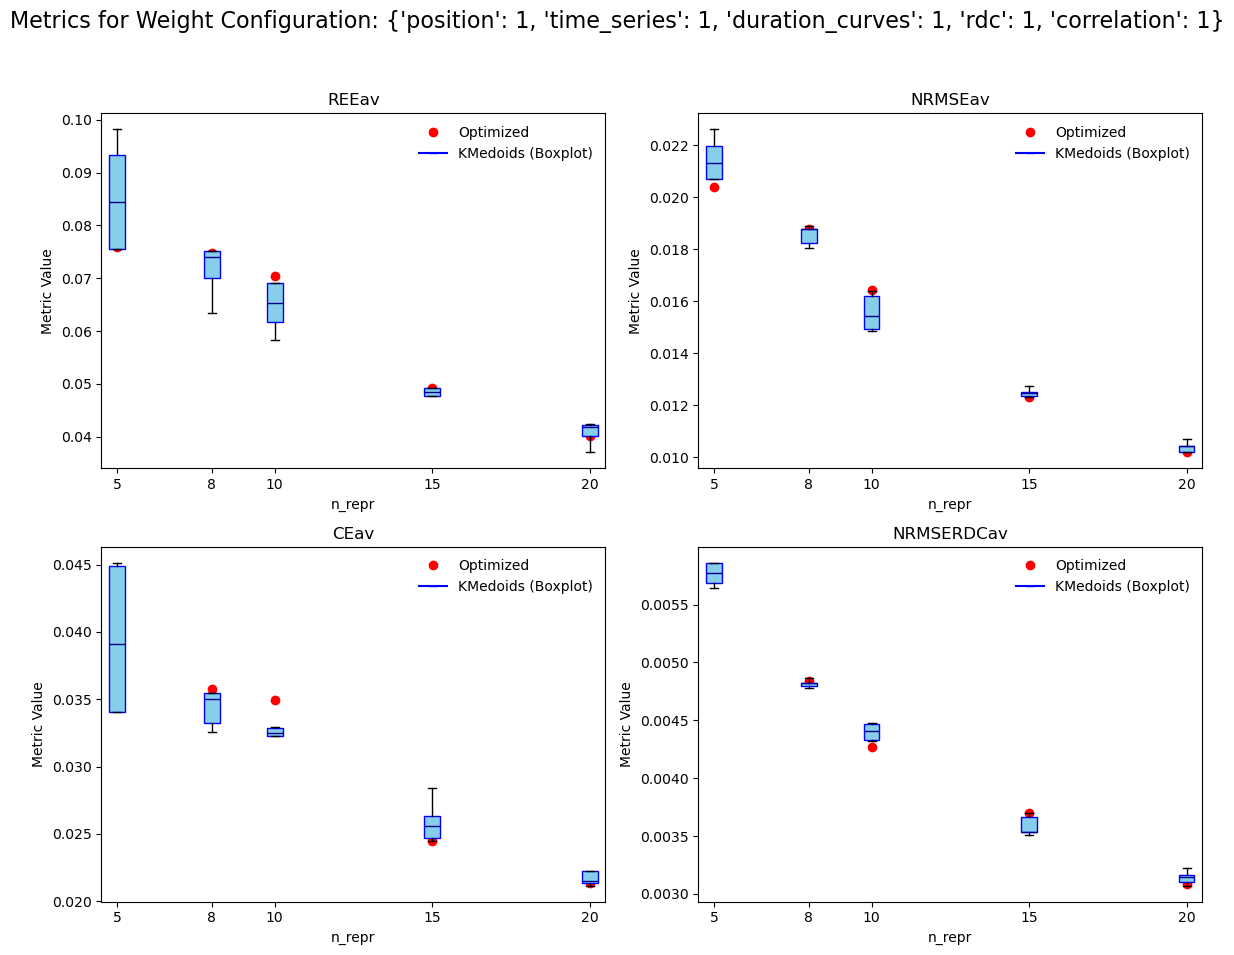

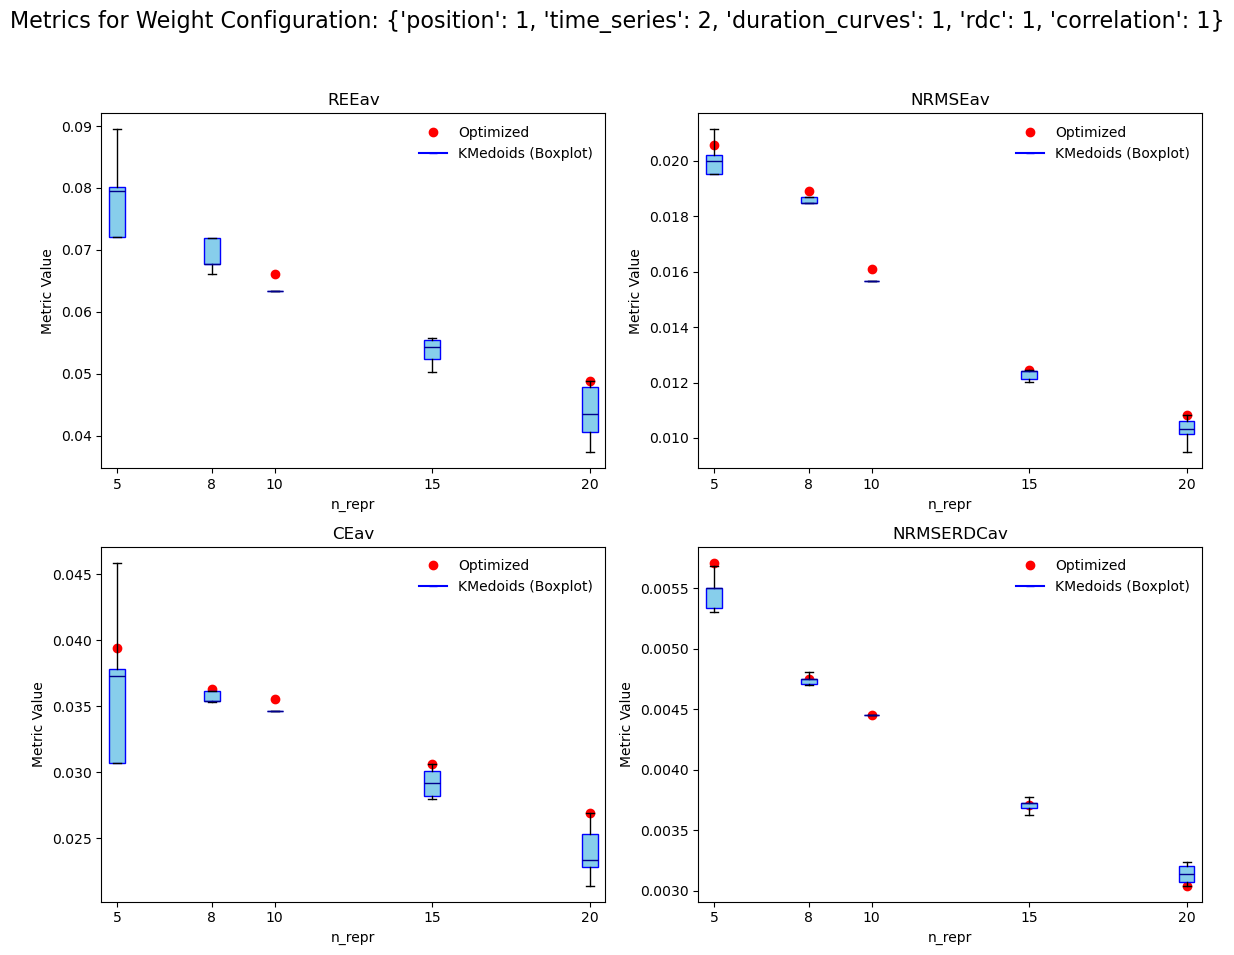

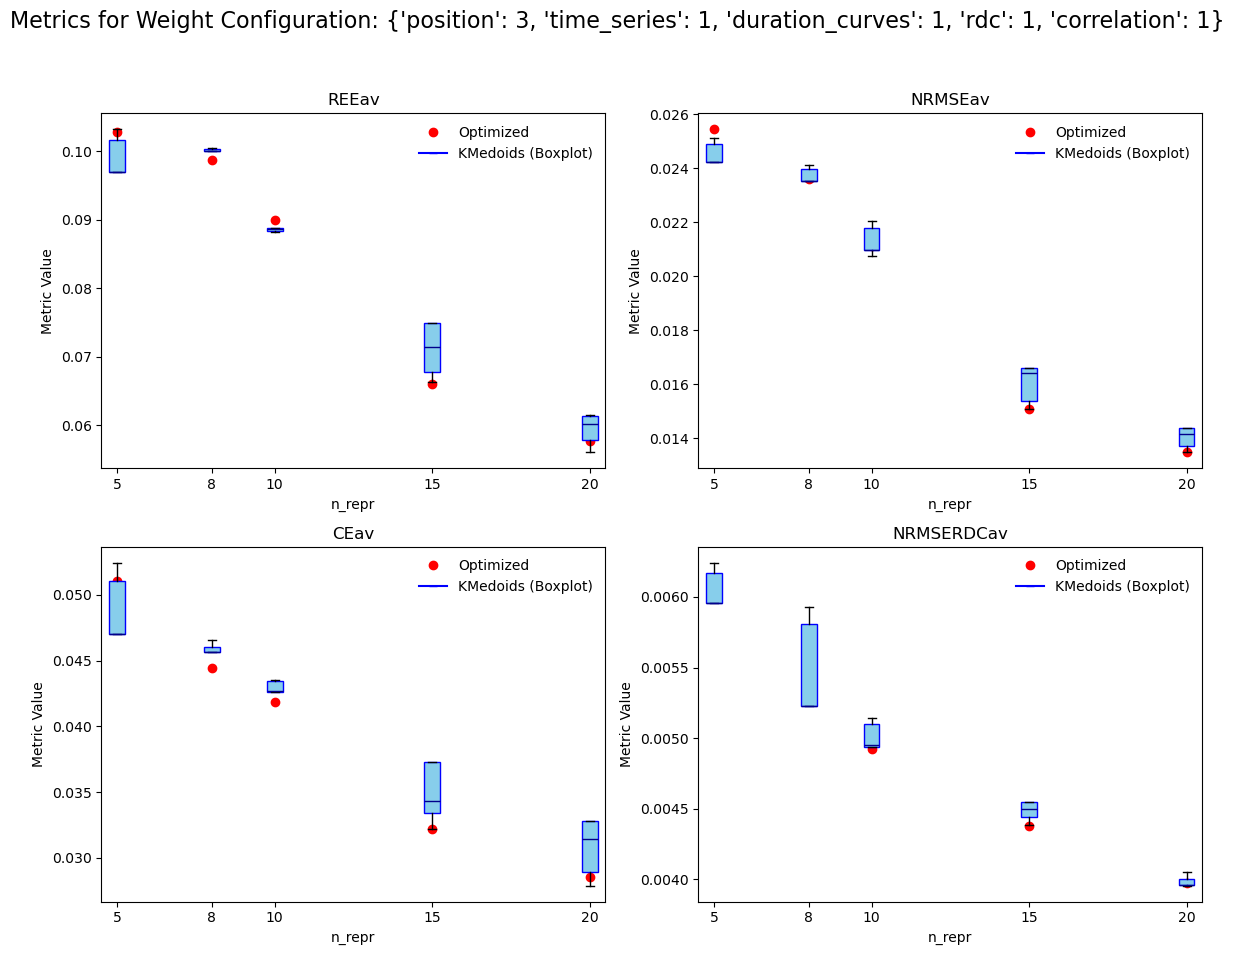

In [38]:
# Metrics to plot
metrics = ['REEav', 'NRMSEav', 'CEav', 'NRMSERDCav']

# Create a DataFrame from results for easier manipulation
data = []
for result in results:
    for metric in metrics:
        data.append({
            'weights': str(result['weights']),
            'n_repr': result['n_repr'],
            'iteration': result['iteration'],
            'metric': metric,
            'optimized_value': result['optimized_metrics'][metric],
            'kmedoids_value': result['kmedoids_metrics'][metric]
        })

df = pd.DataFrame(data)

# Plot for each weight configuration
for weight_config, weight_data in df.groupby('weights'):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Subset data for the current metric
        metric_data = weight_data[weight_data['metric'] == metric]

        # Group by n_repr
        for n_repr, group in metric_data.groupby('n_repr'):
            # Plot candle chart for KMedoids iterations
            kmedoids_iterations = group['kmedoids_value']
            ax.boxplot(
                kmedoids_iterations,
                positions=[n_repr],
                widths=0.5,
                showfliers=False,
                patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='blue'),
                medianprops=dict(color='darkblue')
            )

            # Plot optimized value as a single point
            optimized_value = group['optimized_value'].iloc[0]
            ax.scatter(n_repr, optimized_value, color='red')

        ax.set_title(metric)
        ax.set_xlabel('n_repr')
        ax.set_ylabel('Metric Value')

        # Add legend inside each subplot
        handles = [
            plt.Line2D([0], [0], color='red', marker='o', linestyle='', label='Optimized'),
            plt.Line2D([0], [0], color='blue', marker='_', linestyle='-', label='KMedoids (Boxplot)')
        ]
        ax.legend(handles=handles, loc='best', fontsize=10, frameon=False)

    fig.suptitle(f"Metrics for Weight Configuration: {weight_config}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
